# Libraries

In [1]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [2]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog as rfa, rf_tx_fw, \
    tonegen, digital_filter_design, rx_dfe_impcomp as rx_impcomp, \
        digital_hw_algo as dighw, plotting

reload(calc)
reload(ofdm)
reload(rfa)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(rx_impcomp)
reload(dighw)
reload(plotting)

<module 'rfdsppy.plotting' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/plotting.py'>

# FD RSB

In [11]:
# Generate sample waveform

nsym = 14
modorder = 64
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = 8
wola = 1
wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola)

x, x_standard = wg.generate(nsym)
cfg = wg.get_demod_params()
fs = cfg.get("fs")
wola_len = cfg.get("wola_len")
print(f"Fs (MHz) = {fs}")

Fs (MHz) = 245.76


In [23]:
# Pass through BBF

delta = 0.07

obw = num_sc*scs/1000
wp = obw/fs
ws = (fs/2-2*obw)/(fs/2)
gpass = 6
gstop = 50

b, a = digital_filter_design.iir_bbf(wp, ws, gpass, gstop, en_plot=False)
b_i, a_i = digital_filter_design.iir_bbf(wp*(1+delta), ws*(1-delta), gpass, gstop, en_plot=False)
b_q, a_q = digital_filter_design.iir_bbf(wp*(1-delta), ws*(1+delta), gpass, gstop, en_plot=False)

x_bbf = signal.lfilter(b, a, x)

x_i = signal.lfilter(b_i, a_i, x.real)
x_q = signal.lfilter(b_q, a_q, x.imag)
x_fd_rsb = x_i + 1j*x_q

# py, fy = calc.psd(x_bbf, fs, fs/2**12)
# px, fx = calc.psd(x, fs, fs/2**12)

# fig, axs = plt.subplots(dpi=150)
# axs.plot(fx, 10*np.log10(px), label="BBF Input", linewidth=5)
# axs.plot(fy, 10*np.log10(py), label="BBF Output")
# axs.set_title(f"BBF")
# axs.set_xlabel("Frequency (MHz)")
# axs.set_ylabel("PSD (dBm/Bin)")
# axs.grid()
# axs.legend(loc="lower center")

digital_filter_design.iir_bbf()
Filter order = 3
Maximum passband loss (dB) = 5.825
Minimum stopband attenuation (dB) = 54.4



digital_filter_design.iir_bbf()
Filter order = 3
Maximum passband loss (dB) = 5.959
Minimum stopband attenuation (dB) = 50.1



digital_filter_design.iir_bbf()
Filter order = 3
Maximum passband loss (dB) = 5.671
Minimum stopband attenuation (dB) = 59.4





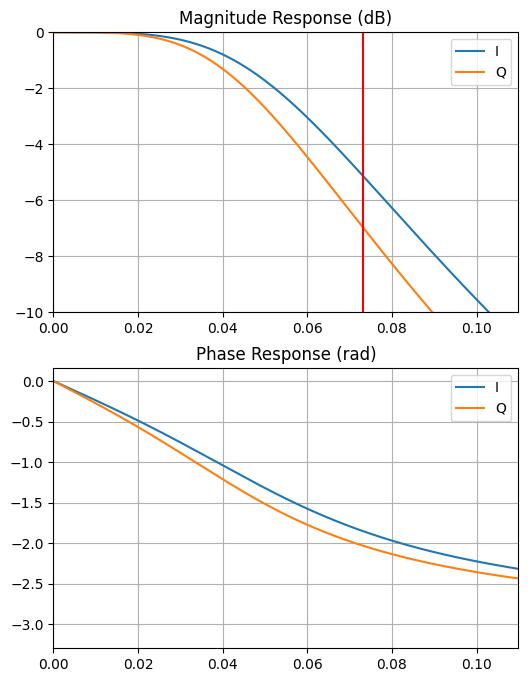

In [24]:
# Visualize the FD mismatch

w, hi = signal.freqz(b_i, a_i, worN=2**16, fs=2)
_, hq = signal.freqz(b_q, a_q, worN=2**16, fs=2)

fig, axs = plt.subplots(nrows=2, dpi=100, figsize=(6, 8))
axs[0].plot(w, 20*np.log10(np.abs(hi)), label="I")
axs[1].plot(w, np.angle(hi), label="I")
axs[0].plot(w, 20*np.log10(np.abs(hq)), label="Q")
axs[1].plot(w, np.angle(hq), label="Q")
axs[0].set_title("Magnitude Response (dB)")
axs[1].set_title("Phase Response (rad)")
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()
axs[0].set_xlim(left=0, right=wp*1.5)
axs[1].set_xlim(left=0, right=wp*1.5)
axs[0].set_ylim(bottom=-10, top=0)
axs[0].vlines([wp], ymin=-20, ymax=0, colors='r')

EVM, no mismatch: 3.08 %
SNR, no mismatch: 30.23 dB
EVM, with mismatch: 9.17 %
SNR, with mismatch: 20.75 dB


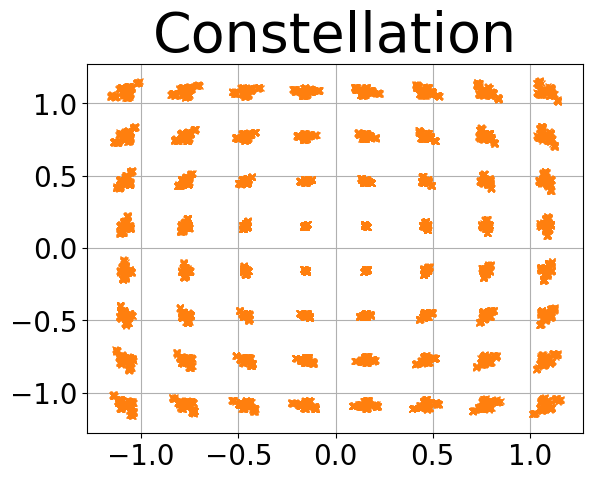

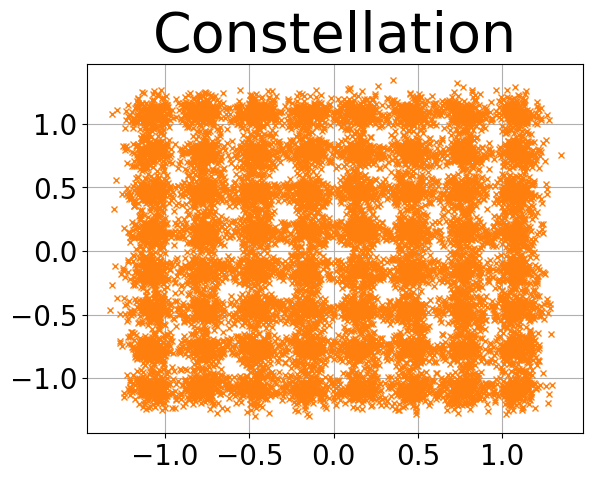

In [25]:
evm = wg.calculate_evm(x[round(wola_len/2):], x_bbf[round(wola_len/2):], en_plot=True, en_fd_eq=True)
print(f"EVM, no mismatch: {round(evm,2)} %")
print(f"SNR, no mismatch: {round(-20*np.log10(evm/100),2)} dB")

evm = wg.calculate_evm(x[round(wola_len/2):], x_fd_rsb[round(wola_len/2):], en_plot=True, en_fd_eq=True)
print(f"EVM, with mismatch: {round(evm,2)} %")
print(f"SNR, with mismatch: {round(-20*np.log10(evm/100),2)} dB")

# Measurement

In [ ]:
# Measure and then try FIR equalizer